# Setup

En este notebook "transribí" el modelo que surgió de las caminatas al azar, el cual estaba armado con base_model. Lo escribi todo a mano para verificar que lo que arma base_model sea lo que corresponde, lo entrene y me fije que tenga la misma performance. Aproveché para ver que pasa si vario el sampleo, lo que me llevó a darme cuenta de que había que regularizar un poco la red.

Para mejorar la regularización aumenté el dropout de la primera capa y dejé el resto fijo. Mi razonamiento fue que esa capa es la que tiene más parámetros, porque el input de las enfermedades tiene dimensión=250. Además samplee negativos nuevos en cada iteración. Esto dio buenos resultados, las curvas de error se plancharon más, pero igual el error de validación es un poco alto.

Mire por qué el error es relativamente alto aunque el AUC es muy bueno. Intuitivamente, pense que el modelo podia estar clasificando muy mal algunos outliers y por eso el error explota (logloss es un promedio!). Para ver si es así tome los datos de entrenamiento y calcule el error, en vez de reducirlo (i.e, promediarlo) como se hace durante entrenamiento, me quedé con todos los valores y los plotee. Sucede masomenos lo que pensaba, el hist. del error decae rápidamente pero hay unos pocos ejemplos donde el modelo comete un error muy grande. Esto me corre el promedio.

Si en lugar del promedio miro la mediana, está mucho más cerca de cero. 

Por otro lado, como lo que nos interesa es "ordenar" cosas, está bien que el modelo no entregue una proba de 0 o 1 en cada caso, necesitamos valores de proba intermedios. Pero estos valores intermedios para log loss están "mal". 

En cambio, para AUC, mientras respete el orden de las probas, está bien.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch_geometric import seed_everything
from torch_geometric.nn import SAGEConv, to_hetero
import seaborn as sns

import sys
sys.path.append("../../..")
from src.models import training_utils, base_model,sage_ones, prediction_utils

seed = 4
seed_everything(seed)

data_folder = f"../../../data/processed/graph_data_nohubs/merged_types/split_dataset/"
feature_folder = "../../../data/processed/feature_data/"
reports_folder = "../../../reports/"
results_folder = "../../../reports/random_walks/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data

In [6]:
walk_1_results = pd.read_csv(results_folder+"walk_3/random_walk_results.csv",index_col=0)
walk_2_results = pd.read_csv(results_folder+"walk_4/random_walk_results.csv",index_col=0)

walk_2_results["walk"] = 4
walk_1_results["walk"] = 3 
total_walk = pd.concat([walk_1_results,walk_2_results]).reset_index(names="walk_index")
total_walk["T"] = total_walk.walk.apply(lambda x: 0.1 if x == 3 else 0.2)

model_params = total_walk.sort_values(by="mean_auc",ascending=False).iloc[0].to_dict()
model_params["supervision_types"] = [("gene_protein","gda","disease")]

In [26]:
seeds = [4]
data = []
for seed in seeds:
    datasets, node_map = training_utils.load_data(data_folder+f"seed_{seed}/")
    data.append(datasets)

full_set = torch.load(data_folder+f"seed_{seeds[-1]}/full_dataset.pt")
node_df = pd.read_csv(data_folder+f"seed_{seeds[-1]}/tensor_df.csv",index_col=0).set_index("node_index",drop=True)

# Trato de escribir el modelo a mano

In [23]:
class GraphBlock(torch.nn.Module):
    def __init__(self,input_dim,output_dim,dropout,residual_block):
        super().__init__()

        self.residual_block = residual_block
        self.conv = SAGEConv(input_dim,output_dim,aggr="mean")
        self.bn = torch.nn.BatchNorm1d(output_dim)
        self.dropout = torch.nn.Dropout(dropout)
        self.relu = torch.nn.LeakyReLU()
    
    def forward(self,x,edge_index):
        identity = x
        out = self.conv(x,edge_index)
        out = self.bn(out)
        out = self.dropout(out)
        out = self.relu(out)

        if self.residual_block:
            out += identity
            out = torch.nn.functional.leaky_relu(out)
        
        return out

    def reset_parameters(self):
        self.conv.reset_parameters()
        self.bn.reset_parameters()

    
class PostProcessMLP(torch.nn.Module):
    def __init__(self,input_dim,output_dim,dropout):
        super().__init__()

        self.post_linear_1 = torch.nn.Linear(input_dim,output_dim)
        self.post_linear_bn = torch.nn.BatchNorm1d(output_dim)
        self.post_linear_dropout = torch.nn.Dropout(dropout)
        self.post_linear_act = torch.nn.LeakyReLU()
        self.post_linear_2 = torch.nn.Linear(output_dim,output_dim)

    def forward(self,x):
        x = self.post_linear_1(x)
        x = self.post_linear_bn(x)
        x = self.post_linear_dropout(x)
        x = self.post_linear_act(x)
        x = self.post_linear_2(x)

        return x
    
    def reset_parameters(self):
        self.post_linear_1.reset_parameters()
        self.post_linear_bn.reset_parameters()
        self.post_linear_2.reset_parameters()

class Encoder(torch.nn.Module):
    def __init__(self,output_dim,dropout,metadata):
        super().__init__()

        self.graph_layer_1 = to_hetero(GraphBlock(-1,output_dim,0.4,False),metadata,aggr="mean")
        self.graph_layer_2 = to_hetero(GraphBlock(output_dim,output_dim,dropout,True),metadata,aggr="mean")
        self.graph_layer_3 = to_hetero(GraphBlock(output_dim,output_dim,dropout,True),metadata,aggr="mean")
        self.post_mlp = to_hetero(PostProcessMLP(output_dim,output_dim,dropout),metadata)

    
    def forward(self,x:dict,edge_index:dict):
        x = self.graph_layer_1(x,edge_index)
        x = self.graph_layer_2(x,edge_index)
        x = self.graph_layer_3(x,edge_index)
        x = self.post_mlp(x)
        return x

class InnerProductDecoder(torch.nn.Module):
    def __init__(self,supervision_types):
        super().__init__()
        self.supervision_types = supervision_types

    def forward(self,x:dict,edge_label_index:dict) -> dict:
        pred_dict = {}
        for edge_type in self.supervision_types:
            edge_index = edge_label_index[edge_type]

            source_type, _ , target_type = edge_type
            
            x_source = x[source_type]
            x_target = x[target_type]

            source_index, target_index = edge_index[0], edge_index[1]

            nodes_source = x_source[source_index]
            nodes_target = x_target[target_index]

            pred = (nodes_source * nodes_target).sum(dim=1)

            pred = torch.sigmoid(pred)
            pred_dict[edge_type] = pred
        
        return pred_dict

class Model(torch.nn.Module):
    def __init__(self,metadata,supervision_types):
        super().__init__()
          
        self.encoder = Encoder(64,0.1,metadata)
        self.decoder = InnerProductDecoder(supervision_types)
        self.loss_fn = torch.nn.BCELoss()
        self.supervision_types = supervision_types
    
    
    def forward(self,x:dict,edge_index:dict,edge_label_index:dict) -> dict:
        x = self.encoder(x,edge_index)
        pred = self.decoder(x,edge_label_index)
        return pred
    
    def loss(self, prediction_dict, label_dict):
        loss = 0
        for edge_type,pred in prediction_dict.items():
            y = label_dict[edge_type]
            loss += self.loss_fn(pred, y.type(pred.dtype))
        return loss

# Run experiment aver si funciona igual

In [24]:
model_params["sample_epochs"] = 1
pd.DataFrame.from_dict(model_params).T

,0
walk_index,22
hidden_channels,64
micro_aggregation,mean
macro_aggregation,mean
layer_connectivity,skipsum
L2_norm,False
pre_process_layers,0
msg_passing_layers,3
post_process_layers,2
normalize_output,False


In [13]:
def run_experiment(params, train_set, val_set,negative_sampler):
    # Initialize node features
    if params["feature_type"] not in ["lsa","lsa_norm","lsa_scaled"]:
        train_set = training_utils.initialize_features(
            train_set, params["feature_type"], params["feature_dim"]
        )
        val_set = training_utils.initialize_features(
            val_set, params["feature_type"], params["feature_dim"]
        )
    else:
        #TODO: sacar el data_folder este
        train_set = training_utils.initialize_features(
            train_set, params["feature_type"], params["feature_dim"], feature_folder
        )
        val_set = training_utils.initialize_features(
            val_set, params["feature_type"], params["feature_dim"], feature_folder
        )

    train_set.to(device)
    val_set.to(device)
    model = Model(train_set.metadata(),[("gene_protein","gda","disease")])
    model = model.to(device)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"]
    )
    train_losses = []
    val_losses = []
    train_scores = []
    val_scores = []

    epochs = params["epochs"]

    early_stopper = training_utils.EarlyStopper(params["patience"], params["delta"])
    train_label_index = train_set["gene_protein","gda","disease"]["edge_label_index"]
    for epoch in range(epochs):
        #Resample negative supervision links every k epochs
        if epoch%params["sample_epochs"] == 0:
            # sample_index = torch.randint(high=train_label_index.shape[1], size=(round(params["sample_ratio"]*train_label_index.shape[1]),))
            # positive_sample = train_label_index[:,sample_index]

            # positive_sample = train_label_index
            new_train_label_index, new_train_label = negative_sampler.get_labeled_tensors(train_label_index.cpu(),"corrupt_both")
            train_set["gene_protein","gda","disease"]["edge_label_index"] = new_train_label_index.to(device)
            train_set["gene_protein","gda","disease"]["edge_label"] = new_train_label.to(device)

        train_loss = training_utils.train(model, optimizer, train_set)
        val_loss = training_utils.get_val_loss(model, val_set)

        train_score = training_utils.test(model, train_set)
        val_score = training_utils.test(model, val_set)

        train_losses.append(train_loss)
        train_scores.append(train_score)

        val_scores.append(val_score)
        val_losses.append(val_loss)

        if early_stopper.early_stop(val_loss):
            print("Early stopping")
            break

    val_auc = training_utils.test(model, val_set)
    curve_data = [train_losses, val_losses, train_scores, val_scores]

    return val_auc, model, curve_data

def run_multiple_seeds(datasets,experiment_params,negative_sampler):
    experiment_metrics = []
    models = []
    curves = []
    for seed_dataset in datasets:
        train_data, val_data = seed_dataset
        seed_auc, trained_model, training_curve = run_experiment(experiment_params,train_data,val_data,negative_sampler)
        experiment_metrics.append(seed_auc)
        models.append(trained_model)
        curves.append(training_curve)
    
    metrics = (np.mean(experiment_metrics),np.std(experiment_metrics))
    
    return [metrics, models, curves]

(0.901, 0.0)


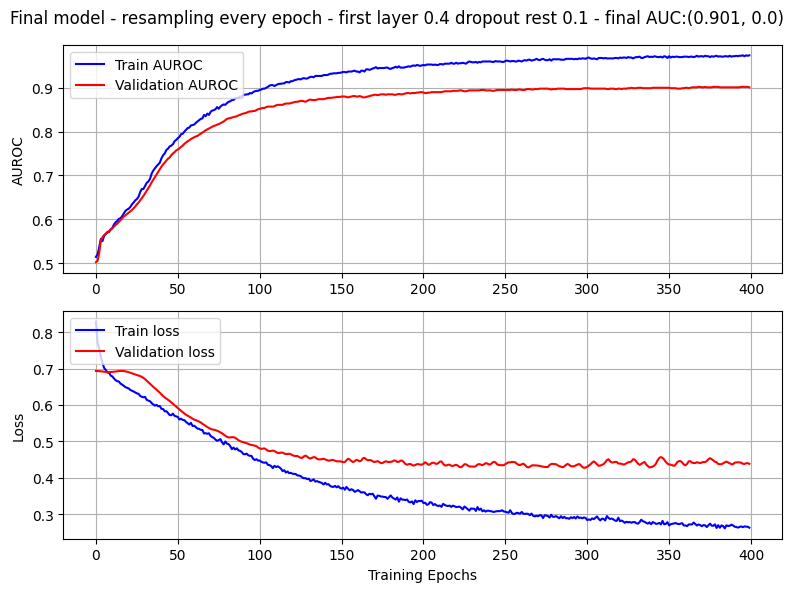

In [27]:
negative_sampler = training_utils.NegativeSampler(full_set,("gene_protein","gda","disease"),full_set["gene_protein"]["degree_gda"],full_set["disease"]["degree_gda"])
results = {}

metrics,models,curves = run_multiple_seeds(data,model_params,negative_sampler)
print(metrics)

training_utils.plot_training_stats_sep(f"Final model - resampling every epoch - first layer 0.4 dropout rest 0.1 - final AUC:{metrics}",*curves[0])

## Veo la mediana en vez del promedio

### Train

In [131]:
modelo = models[0]
datos = data[0][0]

datos = training_utils.initialize_features(datos, model_params["feature_type"], model_params["feature_dim"], feature_folder)


train_label_index = datos["gene_protein","gda","disease"]["edge_label_index"]

train_label_index = datos["gene_protein","gda","disease"]["edge_label_index"]
new_train_label_index, new_train_label = negative_sampler.get_labeled_tensors(train_label_index.cpu(),"corrupt_both")

datos["gene_protein","gda","disease"]["edge_label_index"] = new_train_label_index
datos["gene_protein","gda","disease"]["edge_label"] = new_train_label

with torch.no_grad():
    modelo.eval()
    predictions = modelo(datos.x_dict,datos.adj_t_dict,datos.edge_label_index_dict)
    edge_label = datos.edge_label_dict

pred = list(predictions.values())[0]
lab = edge_label[("gene_protein","gda","disease")]

loss_fn = torch.nn.BCELoss(reduction="none")
results = loss_fn(pred,lab)

corte = np.where(lab == 0)[0][0]
positivos = results.numpy()[0:corte]
negativos = results.numpy()[corte:]

casos_names = ["todos","positivos","negativos"]
casos = [np.array(results),positivos,negativos]

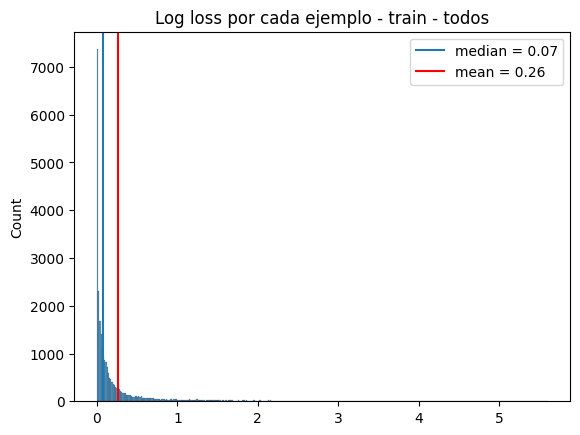

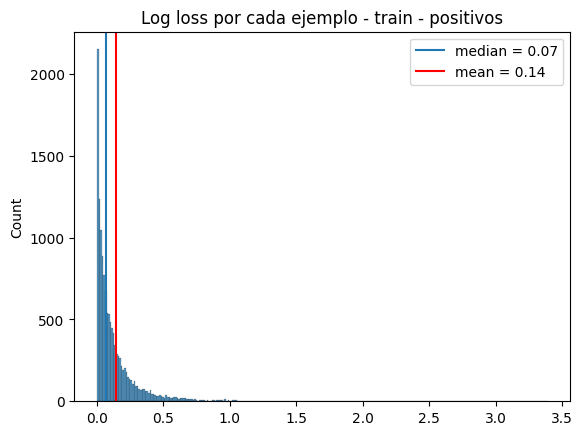

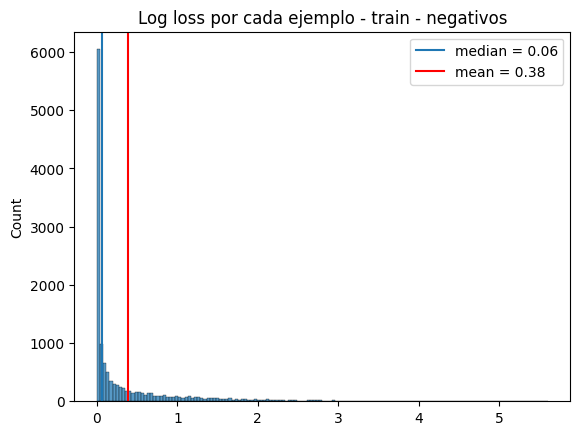

In [107]:
for caso,name in zip(casos,casos_names):
    median = round(np.median(caso),2)
    mean = round(np.mean(caso),2)

    plt.figure()
    sns.histplot(caso)
    plt.axvline(x=median,label=f"median = {median:.2f}")
    plt.axvline(x=mean,c="red",label=f"mean = {mean:.2f}")
    plt.title(f"Log loss por cada ejemplo - train - {name}")
    plt.legend()

### Val

In [124]:
modelo = models[0]
datos_val = data[0][1]

datos_val = training_utils.initialize_features(datos_val, model_params["feature_type"], model_params["feature_dim"], feature_folder)


val_label_index = datos_val["gene_protein","gda","disease"]["edge_label_index"]
#acá no hace falta samplear negativos, val ya tiene negativos "fijos"

with torch.no_grad():
    modelo.eval()
    predictions = modelo(datos_val.x_dict,datos.adj_t_dict,datos_val.edge_label_index_dict)
    edge_label = datos_val.edge_label_dict

pred = list(predictions.values())[0]
lab = edge_label[("gene_protein","gda","disease")]

loss_fn = torch.nn.BCELoss(reduction="none")
val_results = loss_fn(pred,lab)

corte = np.where(lab == 0)[0][0]
val_positivos = val_results.numpy()[0:corte]
val_negativos = val_results.numpy()[corte:]

casos_names = ["todos","positivos","negativos"]
casos = [np.array(val_results),val_positivos,val_negativos]

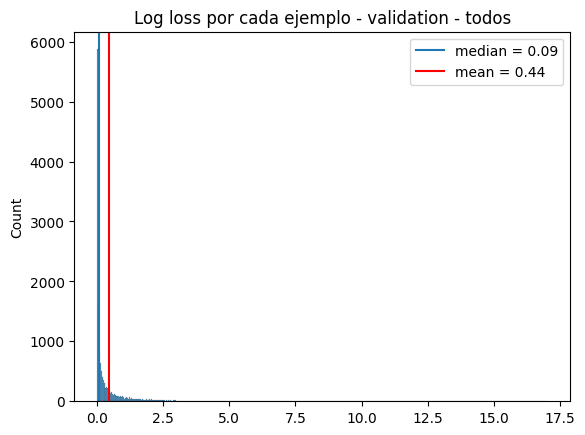

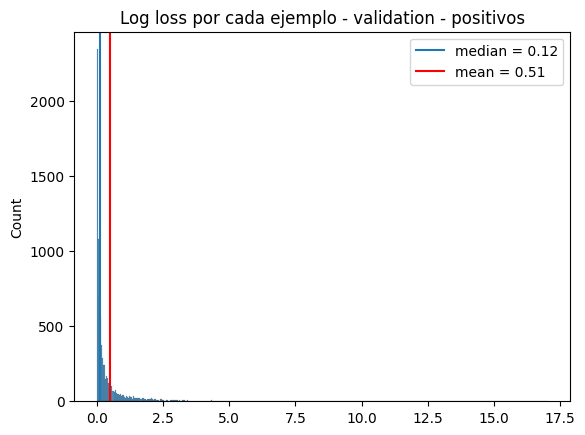

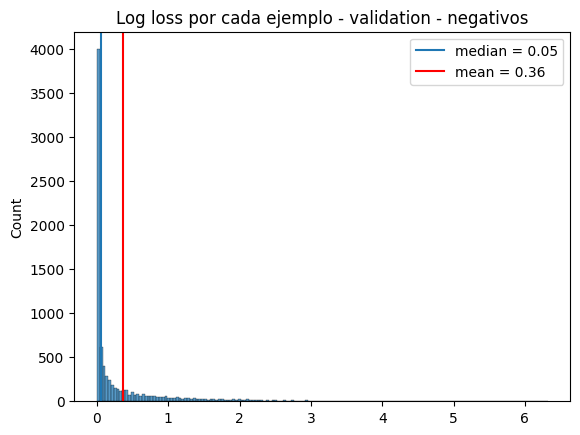

In [125]:
for caso,name in zip(casos,casos_names):
    median = round(np.median(caso),2)
    mean = round(np.mean(caso),2)

    plt.figure()
    sns.histplot(caso)
    plt.axvline(x=median,label=f"median = {median:.2f}")
    plt.axvline(x=mean,c="red",label=f"mean = {mean:.2f}")
    plt.title(f"Log loss por cada ejemplo - validation - {name}")
    plt.legend()


# Ejemplos

Tomo un ejemplo de enlace donde el modelo comete un error muy grande, para ver si es un caso difícil, o si el nodo está desconectado

In [ ]:
mapped_dataset_train = prediction_utils.MappedDataset(datos,node_map,("gene_protein","gda","disease"))
mapped_df_train = mapped_dataset_train.dataframe
mapped_df_train = mapped_df_train.rename(columns={x: x.replace("_source","").replace("_target","") for x in mapped_df_train.columns})

mapped_dataset_val = prediction_utils.MappedDataset(datos_val,node_map,("gene_protein","gda","disease"))
mapped_df_val = mapped_dataset_val.dataframe
mapped_df_val = mapped_df_val.rename(columns={x: x.replace("_source","").replace("_target","") for x in mapped_df_val.columns})

In [172]:
np.where(val_positivos == val_positivos.max())

(array([1348]),)

In [177]:
index = np.where(val_positivos == val_positivos.max())[0]
edge = (val_label_index[0][index].item(),val_label_index[1][index].item())
gene, disease = edge

In [178]:
node_df[(node_df.tensor_index == gene) & (node_df.node_type == "gene_protein")]

,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
17375,90993,CREB3L1,gene_protein,disgenet,4798,NaN,NaN,3.0,13.0,0.0,16.0


In [179]:
node_df[(node_df.tensor_index == disease)&(node_df.node_type == "disease")]

,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
31709,C3714524,Fibromyxosarcoma,disease,disgenet,9203,21.0,7.0,3.0,0.0,1.0,4.0


In [180]:
mapped_df_val[mapped_df_val.torch_disease_index == disease]

,gene_protein,disease,torch_gene_protein_index,torch_disease_index,label,edge_type
1348,17375,31709,4798,9203,1.0,supervision
13720,2830,31709,9920,9203,0.0,supervision
62321,13495,31709,4802,9203,NaN,message_passing


In [181]:
mapped_df_val[mapped_df_val.torch_gene_protein_index == gene]

,gene_protein,disease,torch_gene_protein_index,torch_disease_index,label,edge_type
1348,17375,31709,4798,9203,1.0,supervision
40168,17375,22992,4798,1533,NaN,message_passing
55473,17375,32407,4798,5528,NaN,message_passing


In [182]:
mapped_df_train[mapped_df_train.torch_disease_index == disease]

,gene_protein,disease,torch_gene_protein_index,torch_disease_index,label,edge_type
18598,9318,31709,3559,9203,0.0,supervision
49845,13495,31709,4802,9203,NaN,message_passing


In [183]:
mapped_df_train[mapped_df_train.torch_gene_protein_index == gene]

,gene_protein,disease,torch_gene_protein_index,torch_disease_index,label,edge_type
18849,17375,20401,4798,4810,0.0,supervision
32073,17375,22992,4798,1533,NaN,message_passing
44377,17375,32407,4798,5528,NaN,message_passing


Ok, son dos nodos medio mal conectados que no tuvieron mucha data de entrenamiento además. Ambos tienen de supervisión un enlace negativo nada más.

### Otros ejemplos

Casos positivos:

In [184]:
top_5 = np.argsort(val_positivos)[:5]
worst_5 = np.argsort(val_positivos)[-5:]

In [185]:
for index in top_5:
    edge = (val_label_index[0][index].item(),val_label_index[1][index].item())
    gene, disease = edge
    display(node_df[(node_df.tensor_index == gene) & (node_df.node_type == "gene_protein")])
    display(node_df[(node_df.tensor_index == disease)&(node_df.node_type == "disease")])
    print("--------------------------------")
    

,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
17523,9187,SLC24A1,gene_protein,disgenet,17646,NaN,NaN,10.0,3.0,0.0,13.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
29001,C1864877,"NIGHT BLINDNESS, CONGENITAL STATIONARY, TYPE 2...",disease,disgenet,9599,687.0,12.0,12.0,0.0,1.0,13.0


--------------------------------


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
14097,6921,ELOC,gene_protein,disgenet,1711,NaN,NaN,6.0,71.0,0.0,77.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
18834,C0007134,Renal Cell Carcinoma,disease,disgenet,1405,135.0,3.0,128.0,0.0,10.0,138.0


--------------------------------


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
3386,158584,FAAH2,gene_protein,disgenet,10644,NaN,NaN,6.0,1.0,0.0,7.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
26159,C1266044,Collecting Duct Carcinoma of the Kidney,disease,disgenet,1396,135.0,3.0,128.0,0.0,1.0,129.0


--------------------------------


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
9584,492,ATP2B3,gene_protein,disgenet,1536,NaN,NaN,12.0,25.0,0.0,37.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
21922,C0205650,Papillary adenoma,disease,disgenet,6738,60.0,10.0,36.0,0.0,2.0,38.0


--------------------------------


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
3245,152926,PPM1K,gene_protein,disgenet,10509,NaN,NaN,6.0,5.0,0.0,11.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
20037,C0024776,Maple Syrup Urine Disease,disease,disgenet,6860,384.0,42.0,6.0,0.0,1.0,7.0


--------------------------------


In [189]:
for index in worst_5:
    edge = (val_label_index[0][index].item(),val_label_index[1][index].item())
    gene, disease = edge
    display(node_df[(node_df.tensor_index == gene) & (node_df.node_type == "gene_protein")])
    display(node_df[(node_df.tensor_index == disease)&(node_df.node_type == "disease")])
    print("--------------------------------")
    

,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
9113,440435,GPR179,gene_protein,disgenet,15334,NaN,NaN,11.0,0.0,0.0,11.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
26021,C0949804,Polyomavirus Infections,disease,disgenet,9861,359.0,33.0,7.0,0.0,1.0,8.0


--------------------------------


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
4765,22954,TRIM32,gene_protein,disgenet,2192,NaN,NaN,7.0,34.0,0.0,41.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
25054,C0686353,"Muscular Dystrophies, Limb-Girdle",disease,disgenet,343,277.0,25.0,32.0,0.0,1.0,33.0


--------------------------------


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
13467,6469,SHH,gene_protein,disgenet,16401,NaN,NaN,23.0,10.0,0.0,33.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
23983,C0345354,Radial polydactyly,disease,disgenet,12668,NaN,NaN,2.0,0.0,0.0,2.0


--------------------------------


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
4217,204219,CERS3,gene_protein,disgenet,11627,NaN,NaN,3.0,1.0,0.0,4.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
30040,C2750787,Weill-Marchesani-Like Syndrome,disease,disgenet,869,814.0,85.0,2.0,0.0,1.0,3.0


--------------------------------


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
17375,90993,CREB3L1,gene_protein,disgenet,4798,NaN,NaN,3.0,13.0,0.0,16.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
31709,C3714524,Fibromyxosarcoma,disease,disgenet,9203,21.0,7.0,3.0,0.0,1.0,4.0


--------------------------------


Casos negativos:

In [190]:
top_5 = np.argsort(val_negativos)[:5]
worst_5 = np.argsort(val_negativos)[-5:]

In [191]:
for index in top_5:
    edge = (val_label_index[0][index].item(),val_label_index[1][index].item())
    gene, disease = edge
    display(node_df[(node_df.tensor_index == gene) & (node_df.node_type == "gene_protein")])
    display(node_df[(node_df.tensor_index == disease)&(node_df.node_type == "disease")])
    print("--------------------------------")

,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
9041,4314,MMP3,gene_protein,disgenet,14435,NaN,NaN,42.0,15.0,0.0,57.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
25198,C0750935,Cerebral Astrocytoma,disease,disgenet,1412,110.0,28.0,25.0,0.0,1.0,26.0


--------------------------------


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
17365,9095,TBX19,gene_protein,disgenet,17620,NaN,NaN,7.0,0.0,0.0,7.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
23227,C0271583,"ACTH Deficiency, Isolated",disease,disgenet,7964,837.0,35.0,1.0,0.0,1.0,2.0


--------------------------------


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
6091,2657,GDF1,gene_protein,disgenet,13224,NaN,NaN,17.0,1.0,0.0,18.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
22862,C0266642,Situs ambiguus,disease,disgenet,3594,212.0,21.0,15.0,0.0,1.0,16.0


--------------------------------


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
15110,79571,GCC1,gene_protein,disgenet,6622,NaN,NaN,10.0,8.0,0.0,18.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
18809,C0006870,Cannabis Dependence,disease,disgenet,4377,435.0,0.0,17.0,0.0,1.0,18.0


--------------------------------


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
5323,23657,SLC7A11,gene_protein,disgenet,12645,NaN,NaN,3.0,5.0,0.0,8.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
19102,C0011616,Contact Dermatitis,disease,disgenet,2138,62.0,17.0,71.0,0.0,4.0,75.0


--------------------------------


In [192]:
for index in worst_5:
    edge = (val_label_index[0][index].item(),val_label_index[1][index].item())
    gene, disease = edge
    display(node_df[(node_df.tensor_index == gene) & (node_df.node_type == "gene_protein")])
    display(node_df[(node_df.tensor_index == disease)&(node_df.node_type == "disease")])
    print("--------------------------------")

,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
8237,387,RHOA,gene_protein,disgenet,1593,NaN,NaN,46.0,165.0,0.0,211.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
19746,C0020981,Angioimmunoblastic Lymphadenopathy,disease,disgenet,7488,NaN,NaN,4.0,0.0,0.0,4.0


--------------------------------


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
2929,146279,TEKT5,gene_protein,disgenet,10078,NaN,NaN,1.0,0.0,0.0,1.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
20754,C0036341,Schizophrenia,disease,disgenet,1,0.0,0.0,883.0,0.0,1.0,884.0


--------------------------------


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
7885,3589,IL11,gene_protein,disgenet,14520,NaN,NaN,29.0,4.0,0.0,33.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
19203,C0013604,Edema,disease,disgenet,4463,NaN,NaN,26.0,0.0,0.0,26.0


--------------------------------


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
7983,369,ARAF,gene_protein,disgenet,2265,NaN,NaN,7.0,83.0,0.0,90.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
21481,C0152013,Adenocarcinoma of lung (disorder),disease,disgenet,597,143.0,5.0,206.0,0.0,9.0,215.0


--------------------------------


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
7170,3077,HFE,gene_protein,disgenet,14006,NaN,NaN,26.0,4.0,0.0,30.0


,node_id,node_name,node_type,node_source,tensor_index,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd,total_degree
node_index,,,,,,,,,,,
29864,C2713368,Hematopoetic Myelodysplasia,disease,disgenet,1245,582.0,12.0,29.0,0.0,7.0,36.0


--------------------------------


No estoy segura de ver una tendencia y nose como verlo más ordenado. Mepa que predecir enlaces negativos para nodos de grado alto es más difícil.

# Quiero ver como va logloss respecto al puntaje y la etiqueta para tener un poco más de intuición

In [222]:
pred = list(predictions.values())[0]
lab = edge_label[("gene_protein","gda","disease")]
corte = np.where(lab == 0)[0][0]

error = loss_fn(pred,lab)

pred_positivos = pred.numpy()[0:corte]
error_positivos = error.numpy()[0:corte]
sorted_pos = np.argsort(pred_positivos)

pred_negativos = pred.numpy()[corte:]
error_negativos = error.numpy()[corte:]
sorted_neg = np.argsort(pred_negativos)[::-1]


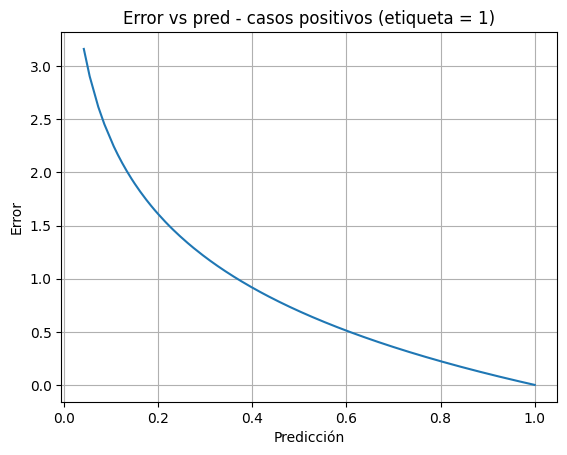

In [231]:
plt.figure()
plt.plot(pred_positivos[sorted_pos],error_positivos[sorted_pos])
plt.xlabel("Predicción")
plt.ylabel("Error")
plt.title("Error vs pred - casos positivos (etiqueta = 1)")
plt.grid()

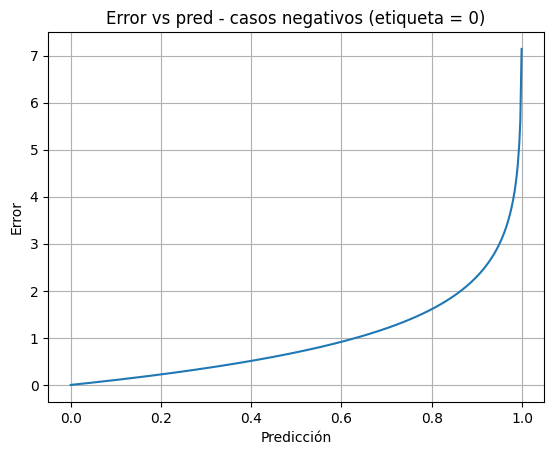

In [232]:
plt.figure()
plt.plot(pred_negativos[sorted_neg],error_negativos[sorted_neg])
plt.xlabel("Predicción")
plt.ylabel("Error")
plt.title("Error vs pred - casos negativos (etiqueta = 0)")
plt.grid()